In [40]:
import re
import random
import pandas as pd
import hashlib

In [41]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate', 'Jane Eyre, Bronte']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [42]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Pandas,201.575634,20.157563,26.899763,10
DAX,376.297790,41.810866,118.636784,9
"Jane Eyre, Bronte",409.648825,58.521261,133.758612,7
Logging in Python,555.089569,61.676619,200.415618,9
Microsoft Purview,736.312498,14.726250,28.394475,50
Azure AD Authentication,990.367812,82.530651,148.421101,12
Azure Functions + PP365,1101.976277,68.873517,231.193641,16
TSQL,1184.031459,49.334644,145.724961,24
Azure VM + Developer,1403.941023,41.292383,126.066060,34
Azure Private DNS,1554.609908,81.821574,416.011498,19


# Histogram

sum of ages: ~47080.19


<Axes: >

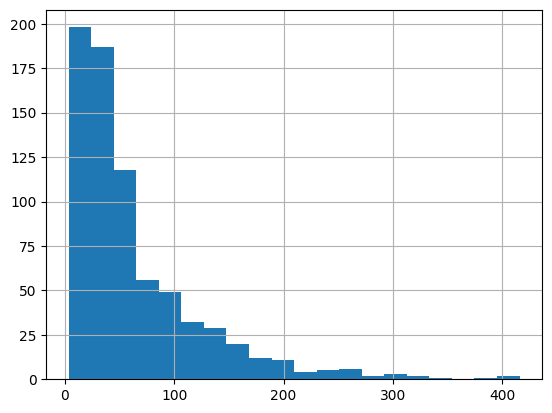

In [43]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~47080.19


<Axes: >

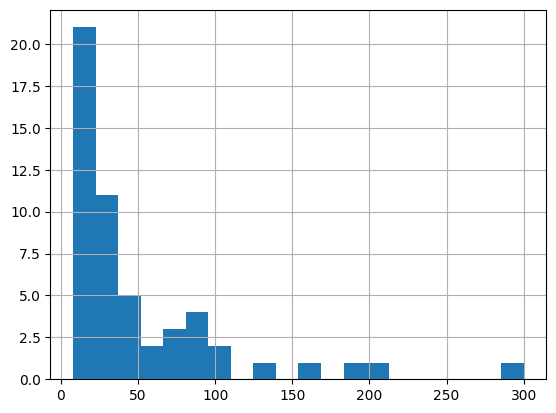

In [44]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [45]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [46]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [47]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [48]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [49]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [50]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [51]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [52]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [53]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [54]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 738
Total card age: 47080.19


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold,neg_age
11,Azure Private DNS,DNS Proxy\nDefinition: A feature that allows D...,7afb51ca2c17c5d23a40fbb536b4ef56,416.011498,81.821574,-416.011498,1554.609908,0.092030,0,0,-416.011498
12,Azure Private DNS,Virtual Network Link\nDefinition: A configurat...,abce8381b58f6e940364806aaedbf8a8,103.522711,81.821574,-416.011498,1554.609908,0.092030,3,0,-103.522711
13,Azure Private DNS,Azure Network Security Groups (NSG)\nDefinitio...,7936a2a4c5a0360ea7ff26767209c9ad,84.695702,81.821574,-416.011498,1554.609908,0.092030,6,0,-84.695702
14,Azure Private DNS,Split-Horizon DNS\nDefinition: A DNS setup whe...,6c84531385a3059c9a965169164204ba,66.289135,81.821574,-416.011498,1554.609908,0.092030,9,0,-66.289135
15,Azure Private DNS,Azure DNS Resolver\nDefinition: The internal D...,d948a2e8c91087517bd82e1fd0f6ef67,41.606304,81.821574,-416.011498,1554.609908,0.092030,12,0,-41.606304
16,Azure Private DNS,PTR Record (Pointer Record):\nDefinition: A DN...,f5ad1355aa665b6794b0b7a464f60147,18.465094,81.821574,-416.011498,1554.609908,0.092030,15,0,-18.465094
520,Azure Private DNS,DNS Conditional Forwarding\nDefinition: A feat...,f4b25b5cde0e89411afdddef4edb9c4a,15.704028,81.821574,-416.011498,1554.609908,0.092030,18,0,-15.704028
18,FSLogix,Q: How does FSLogix Profile Container enhance ...,6e14a79eafeac794c566a2f5be07a49e,404.402881,90.152965,-404.402881,3065.200810,0.702599,0,0,-404.402881
19,FSLogix,Using Cloud Cache puts a performance and stora...,394407955ae7f78e3712d19a98343387,187.888858,90.152965,-404.402881,3065.200810,0.702599,3,0,-187.888858
20,FSLogix,Storage Type (SMB vs. Local Disk):\nThe select...,eec381241da49b681449a938671fed7a,121.810370,90.152965,-404.402881,3065.200810,0.702599,6,0,-121.810370


## Card Count

In [55]:
# n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [56]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [57]:
if existing_cards.age.sum() < 0:
    asc = True
else: asc = False
existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold,neg_age
11,Azure Private DNS,DNS Proxy\nDefinition: A feature that allows D...,7afb51ca2c17c5d23a40fbb536b4ef56,416.011498,81.821574,-416.011498,1554.609908,0.092030,0,0,-416.011498
18,FSLogix,Q: How does FSLogix Profile Container enhance ...,6e14a79eafeac794c566a2f5be07a49e,404.402881,90.152965,-404.402881,3065.200810,0.702599,0,0,-404.402881
30,Terraform,terraform validate:\nA CLI command that checks...,036e232f01695e400da5847ea8babd0d,380.413819,81.878657,-380.413819,1555.694485,0.697208,0,0,-380.413819
36,Python,Q:\nHow can you obtain command-line arguments ...,6a00d6335b8d45302a333e507237865b,338.984484,57.402986,-338.984484,3444.179186,0.164233,0,0,-338.984484
56,Asynchronous Python,asyncio.gather()\nRuns multiple asynchronous P...,88e88ee301ac734f3b1f136e405d3cfd,323.914469,89.375784,-323.914469,3664.407142,0.469409,0,0,-323.914469
70,C# Basics,What’s the difference between delegates and ev...,aafda82832da4aaff149c8153e06fc0a,320.807705,74.717273,-320.807705,2316.235475,0.081550,0,0,-320.807705
81,Azure DevOps Pipelines,"In Azure DevOps, what is the use of the strate...",22834b179fc5b8002c41682d03a4bac2,306.073648,91.386425,-306.073648,2193.274209,0.773407,0,0,-306.073648
246,Azure Developer Associate,Setting environment variables in your containe...,f6675da8ee24b7af11b76dd7d7bf7038,300.142469,52.459937,-300.142469,2780.376642,0.757987,0,0,-300.142469
273,FSLogix,"Cloud Cache uses the concept of a proxy file, ...",78203bab9238f47ee752697bba4135a5,297.288756,90.152965,-404.402881,3065.200810,0.702599,1,1,-297.288756
310,Asynchronous Python,asyncio.wait_for()\nRuns a coroutine with a ti...,0ccadcbce46e58eb4de4907f7e86cbf9,281.914808,89.375784,-323.914469,3664.407142,0.469409,1,1,-281.914808


In [58]:
existing_cards['age'].mean()

63.79429194550814